In [1]:
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath(".."))
from models.xgboost import (create_lagged_features, create_model,
                            evaluate_model, get_autocorrelation_lags,
                            train_model)
from utils.plotting import plot_train_val, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              add_weather_forecast, interpolate_missing_hours,
                              split_train_val)

In [2]:
df_raw = pd.read_csv('../data/cons_sthlm_mean.csv')

df = interpolate_missing_hours(df_raw)
df = add_time_based_features(df)

spot_price_path = '../data/spotprices.csv'
se_area = 'SE3'
df = add_spotprice(df, spot_price_path, se_area)

weather_path = '../data/open-meteo-stockholm.csv'
#columns_to_add = ['temperature_2m', 'precipitation', 'wind_speed_10m', 'uv_index', 'direct_radiation', 'diffuse_radiation']
columns_to_add = ['temperature_2m', 'precipitation', 'direct_radiation', 'uv_index', 'wind_speed_10m']
df = add_weather_forecast(df, weather_path, columns_to_add)

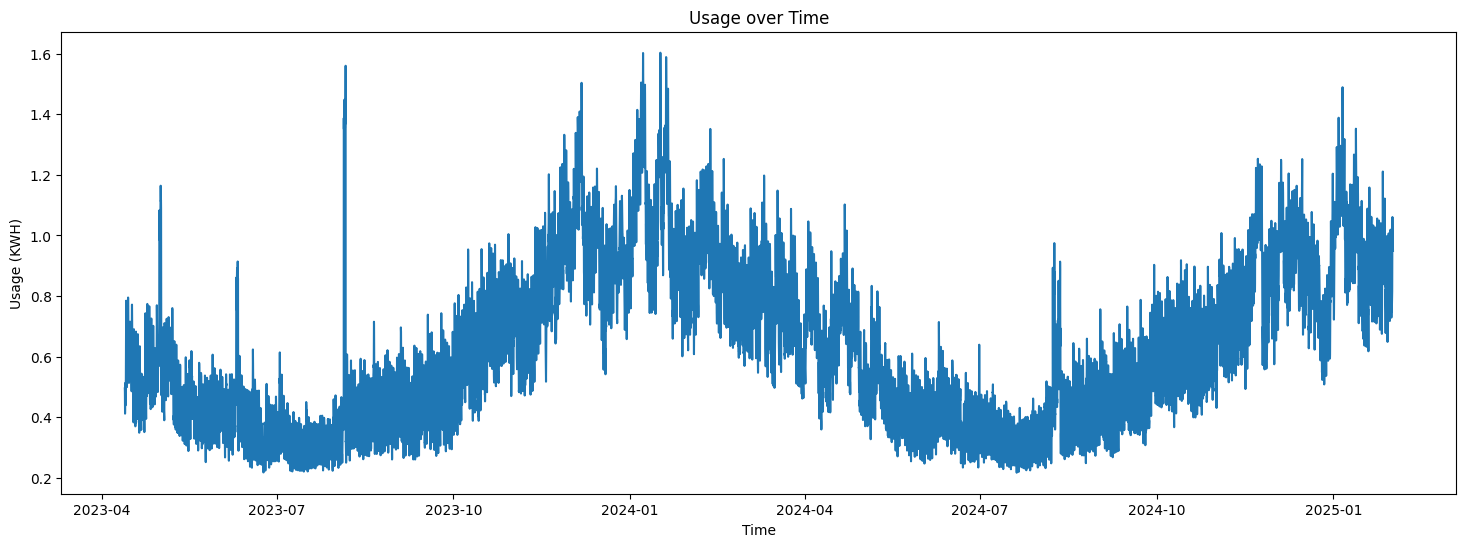

In [3]:
plot_usage(df)

In [4]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,USAGE_KWH,SPOTPRICE_SEK_BY_KWH,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m
0,2023-04-13 00:00:00+00:00,4,13,3,0,0.495219,0.01136,7.9,0.0,0.0,0.0,15.8
1,2023-04-13 01:00:00+00:00,4,13,3,1,0.484958,0.01009,7.5,0.0,0.0,0.0,16.2
2,2023-04-13 02:00:00+00:00,4,13,3,2,0.432565,0.01122,7.7,0.0,0.0,0.0,11.2
3,2023-04-13 03:00:00+00:00,4,13,3,3,0.411980,0.05652,7.9,0.0,0.0,0.0,16.2
4,2023-04-13 04:00:00+00:00,4,13,3,4,0.428065,0.35948,8.0,0.0,0.0,0.0,23.4
...,...,...,...,...,...,...,...,...,...,...,...,...
15835,2025-01-31 20:00:00+00:00,1,31,4,20,0.987562,0.88248,0.7,0.0,0.0,0.0,13.3
15836,2025-01-31 21:00:00+00:00,1,31,4,21,0.995537,0.86239,0.3,0.0,0.0,0.0,14.4
15837,2025-01-31 22:00:00+00:00,1,31,4,22,0.984366,0.51394,-0.0,0.0,0.0,0.0,14.4
15838,2025-01-31 23:00:00+00:00,1,31,4,23,0.967191,0.37785,-0.2,0.0,0.0,0.0,14.8


In [ ]:
autocorr_indexes = get_autocorrelation_lags(df)
df_preprocessed = create_lagged_features(df, lags=autocorr_indexes)

df_preprocessed

Top 3 lags:
[[24, 0.9167353367082159], [25, 0.9064876431284785], [26, 0.8824165346212398]]


,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,USAGE_KWH,SPOTPRICE_SEK_BY_KWH,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,lag_24,lag_25,lag_26
26,2023-04-14 02:00:00+00:00,4,14,4,2,0.499497,0.37709,4.2,0.4,0.0,0.0,16.9,0.432565,0.484958,0.495219
27,2023-04-14 03:00:00+00:00,4,14,4,3,0.504987,0.39218,4.1,0.1,0.0,0.0,16.2,0.411980,0.432565,0.484958
28,2023-04-14 04:00:00+00:00,4,14,4,4,0.527024,0.48599,4.0,0.1,-0.1,0.0,16.6,0.428065,0.411980,0.432565
29,2023-04-14 05:00:00+00:00,4,14,4,5,0.582712,0.62805,4.2,0.1,-0.3,0.1,14.8,0.491729,0.428065,0.411980
30,2023-04-14 06:00:00+00:00,4,14,4,6,0.608186,0.70136,4.3,0.1,0.1,0.1,16.9,0.513344,0.491729,0.428065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,2025-01-31 20:00:00+00:00,1,31,4,20,0.987562,0.88248,0.7,0.0,0.0,0.0,13.3,0.951011,1.000271,1.014976
15836,2025-01-31 21:00:00+00:00,1,31,4,21,0.995537,0.86239,0.3,0.0,0.0,0.0,14.4,0.949868,0.951011,1.000271
15837,2025-01-31 22:00:00+00:00,1,31,4,22,0.984366,0.51394,-0.0,0.0,0.0,0.0,14.4,0.865582,0.949868,0.951011
15838,2025-01-31 23:00:00+00:00,1,31,4,23,0.967191,0.37785,-0.2,0.0,0.0,0.0,14.8,0.854052,0.865582,0.949868


In [6]:
def get_features(df_preprocessed: pd.DataFrame):
    df_features = df_preprocessed.copy()
    df_features = df_features.drop(columns=['USAGE_AT', 'USAGE_KWH'])
    return df_features.values

def get_targets(df_preprocessed: pd.DataFrame):
    df_targets = df_preprocessed.copy()
    df_targets = df_targets['USAGE_KWH']
    return df_targets.values

In [7]:
X, y = get_features(df_preprocessed), get_targets(df_preprocessed)

print(X.shape, y.shape)

(15812, 13) (15812,)


In [8]:
train_split = 0.9
scaler_type = 'minmax'

X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, train_split, scaler_type, device=None)

Applying minmax scaling.
X_train shape: (14230, 13)
y_train shape: (14230, 1)
X_val shape: (1582, 13)
y_val shape: (1582, 1)


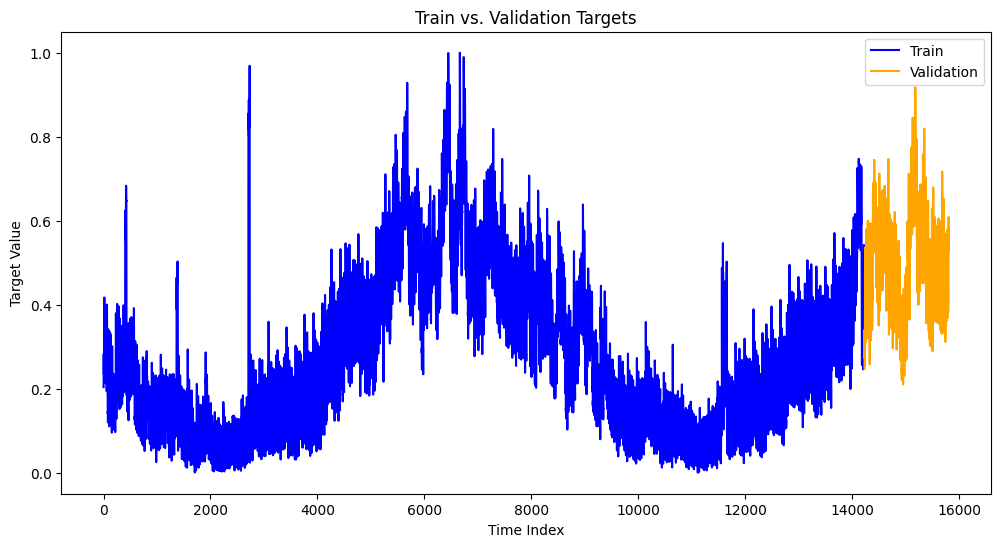

In [9]:
plot_train_val(y_train, y_val)

In [10]:
n_estimators = 10000
lr = 0.05
random_state = 42

model = create_model(n_estimators, lr, random_state)

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
trained_model = train_model(model, X_train, y_train)

MAE: 0.0489
MAPE: 5.37%
RMSE: 0.0635
kWh actual: 1420.360815095429, kWh pred: 1370.209716796875, diff (%): 3.5308703088365956


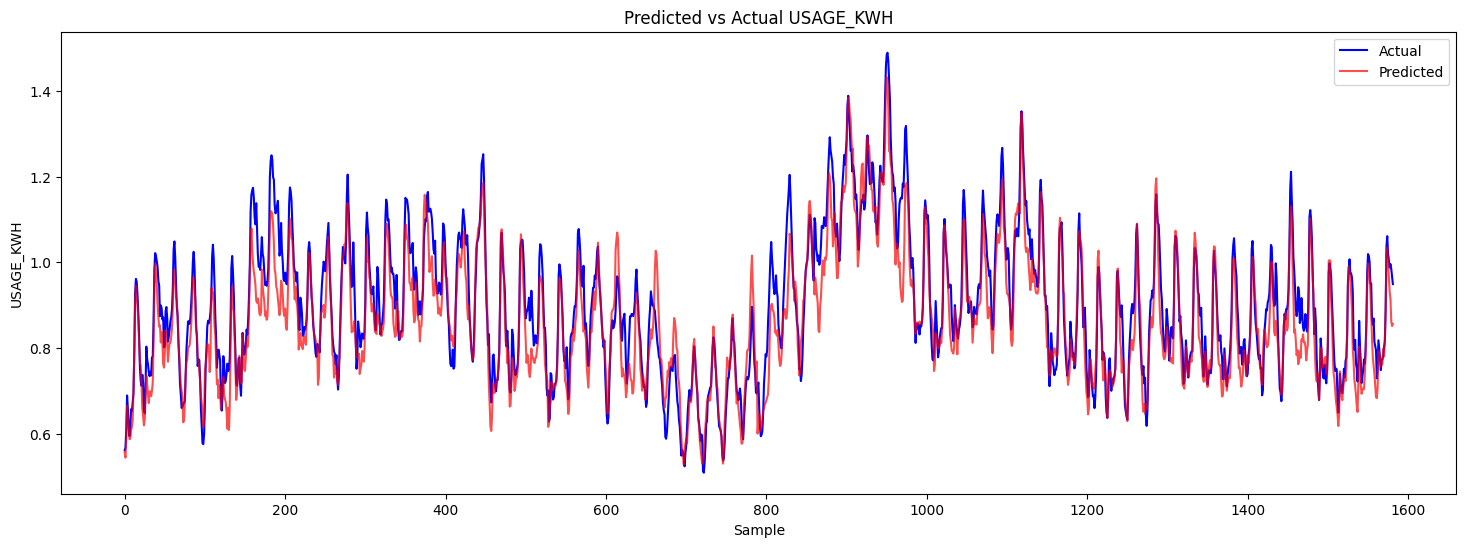

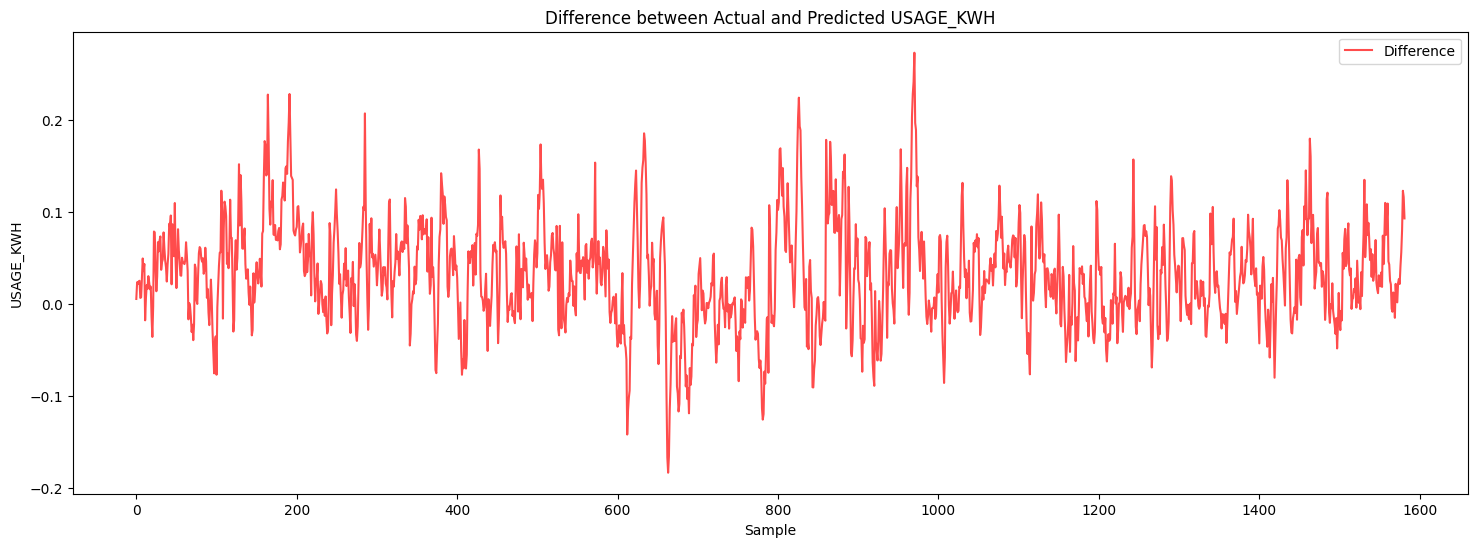

In [12]:
_ = evaluate_model(trained_model, X_val, y_val, scaler_y)